In [1]:
from load_data import *
# from binary_architecture import *
from multiclass_architecture import *
from train_and_test import *
import pandas as pd

In [ ]:
def get_images(image_random_state=0, binary=True):
    train_images, train_labels, _, test_images, test_labels, _ = load_n_images(1200, random_state=image_random_state)
    if binary:
        train_labels = np.array([0 if x < 5 else 1 for x in train_labels])
        test_labels = np.array([0 if x < 5 else 1 for x in test_labels])
    return train_images, train_labels, test_images, test_labels

def one_cnn_run(args, seed, train_images, train_labels, test_images, test_labels):
    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Prepare data loaders
    train_dataset = TensorDataset(torch.Tensor(train_images).unsqueeze(1), torch.Tensor(train_labels).long())
    train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

    test_dataset = TensorDataset(torch.Tensor(test_images).unsqueeze(1), torch.Tensor(test_labels).long())
    test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False)

    # Instantiate models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder = Encoder(args).to(device)
    classifier = Class_out(args).to(device)
    conf_out = Conf_out(args).to(device)

    # Define loss functions and optimizer
    criterion_class = nn.CrossEntropyLoss()
    criterion_conf = nn.BCELoss()  # Binary Cross Entropy for confidence prediction
    optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()) + list(conf_out.parameters()), lr=args.learning_rate)

    # Run the CNN denoise training loop
    best_model, test_z, stats, predicted_labels, true_labels, all_class_preds, all_conf_preds = CNN_denoise(
        encoder=encoder,
        classifier=classifier,
        conf_out=conf_out,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion_class=criterion_class,
        criterion_conf=criterion_conf,
        optimizer=optimizer,
        device=device
    )

    # Return or log the results
    results = {
        'best_model': best_model,
        'stats': stats
    }

    # one_cnn_stats = stats
    # print(one_cnn_stats)

    # Return the results
    return results, test_z, predicted_labels, true_labels, all_class_preds, all_conf_preds

# Hyperparameters
class Args:
    latent_dim = 100 # this would cause PCA testing accuracy to go up
    train_batch_size = 32
    test_batch_size = 100
    epochs = 5
    learning_rate = 0.001

args = Args()

def clean_one_cn(all_class_preds, all_conf_preds, true_labels, predicted_labels):
    # column names: digit 0-9 + 'cnn'
    class_preds = pd.DataFrame(columns=[str(i) + '_cnn' for i in range(10)])
    class_confs = []
    for i in [0,1,2]:
        batch = np.array(all_class_preds[i])
        batch_conf = np.array(all_conf_preds[i])
        label = np.array(true_labels[i])
        pred = np.array(predicted_labels[i])
        # convert each item (a list of one item) to just an item
        batch_conf = [x[0] for x in batch_conf]
        batch_df = pd.DataFrame(batch, columns=[str(i) + '_cnn' for i in range(10)])
        batch_df = batch_df.apply(lambda x: np.exp(x) / np.sum(np.exp(x)), axis=1)
        batch_df['true_label'] = label
        batch_df['predicted_label_cnn'] = pred
        class_preds = pd.concat([class_preds, batch_df]) 
        class_confs.extend(batch_conf)
    class_preds['confidence_cnn'] = class_confs
    return class_preds.reset_index(drop=True)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

def clean_one_rf(confidence_scores, predicted_labels, test_labels, training_indices):
    rf_preds = pd.DataFrame(confidence_scores, columns=[str(i) + '_rf' for i in range(10)])
    rf_preds['predicted_label_rf'] = predicted_labels
    # use the training indices to get the true labels
    rf_preds['true_label'] = test_labels[np.delete(np.arange(300), training_indices)]
    rf_preds['confidence_rf'] = np.max(confidence_scores, axis=1)
    # generate a list of 0-299, then remove indices that were used for training
    list_of_indices = np.arange(300)
    list_of_indices = np.delete(list_of_indices, training_indices)
    rf_preds['testing_index'] = list_of_indices 
    return rf_preds

# Assuming `test_labels` is a list of true labels for the 300 samples
# Assuming `all_test_z` is a list of 10 arrays, each of shape (300, 100)
def RandomForest(all_test_z, test_labels, seed):
    # Step 1: Combine all_test_z into a single array of shape (300, 1000)
    all_test_z_combined = np.hstack(all_test_z)

    np.random.seed(seed)
    training_indices = np.random.choice(300, 225, replace=False)

    # Step 2: Split the data into training (first 225 samples) and testing (last 75 samples) with corresponding labels
    train_data = all_test_z_combined[training_indices]
    train_labels = test_labels[training_indices]
    test_data = all_test_z_combined[np.delete(np.arange(300), training_indices)]
    test_labels_rf = test_labels[np.delete(np.arange(300), training_indices)]

    # Step 3: Initialize and train RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0)
    rf_model.fit(train_data, train_labels)

    # Step 4: Predict on test data
    predicted_labels = rf_model.predict(test_data)

    # Step 5: Evaluate the model
    accuracy = np.mean(predicted_labels == test_labels_rf)

    # Step 6: Return confidence scores
    confidence_scores = rf_model.predict_proba(test_data)
    max_confidence_scores = np.max(confidence_scores, axis=1)
    avg_confidence = np.mean(max_confidence_scores)
    rf_preds = clean_one_rf(confidence_scores, predicted_labels, test_labels, training_indices)
    return accuracy, avg_confidence, rf_preds

In [19]:
def one_crowd(train_images, train_labels, test_images, test_labels, loop_num=10, args=args):
    # Get the images
    best_models = []
    model_accs = []
    model_confs = []
    many_labels = []

    # Run the CNN denoise training loop
    for seed in range(loop_num):
        results, _, predicted_labels, _, _, _ = one_cnn_run(args, seed, train_images, train_labels, test_images, test_labels)
        best_models.append(results['best_model'])
        model_accs.append(results['stats']['test_acc'])
        model_confs.append(results['stats']['test_conf'])
        labels = []
        for k in range(len(predicted_labels)):
            labels.extend(predicted_labels[k].tolist())
        many_labels.append(np.array(labels))
    return best_models, model_accs, model_confs, many_labels

def crowd_stats(loop_num=10,crowd_num=10,binary=True):
    # use many image random states to generate many crowds and collect their stats
    crowd_accs = []
    crowd_confs = []
    crowd_acc_means = []
    crowd_conf_means = []
    for i in range(crowd_num):
        train_images, train_labels, test_images, test_labels = get_images(i+42, binary=binary)
        _, model_accs, model_confs, many_labels = one_crowd(train_images, train_labels, test_images, test_labels, loop_num)
        crowd_accs.append(model_accs)
        crowd_confs.append(model_confs)
        crowd_acc_means.append(np.mean(model_accs))
        crowd_conf_means.append(np.mean(model_confs))
        print(f'crowd {i+1} done')
    return crowd_accs, crowd_confs, crowd_acc_means, crowd_conf_means

In [20]:
from scipy import stats

crowd_num = 5
loop_num = 5

list_of_rf_accs_rf = []
list_of_rf_confs_rf = []
list_of_rf_accs_ab = []
list_of_rf_confs_ab = []

crowd_acc_means = []
crowd_conf_means = []
majority_accs = []
crowds = pd.DataFrame()

for num in range(crowd_num):
    all_test_z = []
    train_images, train_labels, test_images, test_labels = get_images(image_random_state=num, binary=False)
    model_accs = []
    model_confs = []
    many_labels = []
    all_cnn_preds = pd.DataFrame()

    for seed in range(loop_num):
        results, test_z, predicted_labels, true_labels, all_class_preds, all_conf_preds = one_cnn_run(
                args, seed, train_images, train_labels, test_images, test_labels)
        # get the cleaned predictions
        cnn_preds = clean_one_cn(all_class_preds, all_conf_preds, true_labels, predicted_labels)
        cnn_preds['network'] = seed + 1
        cnn_preds['testing_index'] = np.arange(300)
        all_cnn_preds = pd.concat([all_cnn_preds, cnn_preds], axis=0)

        # store the overall accuracy and confidence
        model_accs.append(results['stats']['test_acc'])
        model_confs.append(results['stats']['test_conf'])

        # turn into numpy array
        test_z = test_z.detach().numpy()
        all_test_z.append(test_z)
        # get the predicted labels
        labels = []
        for k in range(len(predicted_labels)):
            labels.extend(predicted_labels[k].tolist())
        many_labels.append(np.array(labels))
    # majority vote
    labels_array = np.stack(many_labels)
    absolute_majority, _ = stats.mode(labels_array, axis=0)
    absolute_majority = absolute_majority.flatten().tolist()
    absolute_majority_acc = np.mean(np.array(absolute_majority) == test_labels)
    majority_accs.append(absolute_majority_acc)

    # all cnns
    all_cnn_preds['crowd'] = num + 1

    # random forest
    accuracy_rf, avg_confidence_rf, rf_preds = RandomForest(
         all_test_z, test_labels, seed=num)
    list_of_rf_accs_rf.append(accuracy_rf)
    list_of_rf_confs_rf.append(avg_confidence_rf)

    # merge the random forest predictions with the cnn predictions
    # note that there would be some missing values in the random forest predictions
    # because some indices were used for training
    cnn_and_rf_preds = all_cnn_preds.merge(rf_preds, on='testing_index', how='left')
    crowds = pd.concat([crowds, cnn_and_rf_preds], axis=0)
    # collect the results for crowd
    crowd_acc_means.append(np.mean(model_accs))
    crowd_conf_means.append(np.mean(model_confs))

    print(f'crowd {num+1} done')

crowd 1 done
crowd 2 done
crowd 3 done
crowd 4 done
crowd 5 done


In [21]:
# rename 'testing_index' to 'image'
crowds.rename(columns={'testing_index': 'image'}, inplace=True)
# drop true_label_y and rename true_label_x to true_label
crowds.drop(columns='true_label_y', inplace=True)
crowds.rename(columns={'true_label_x': 'true_label'}, inplace=True)
crowds = crowds[['network', 'crowd', 'image', 'true_label', '0_cnn', '1_cnn', '2_cnn', '3_cnn', 
                 '4_cnn', '5_cnn', '6_cnn', '7_cnn', '8_cnn', '9_cnn', 
                 'predicted_label_cnn', 'confidence_cnn', '0_rf', '1_rf', '2_rf', '3_rf', 
                 '4_rf', '5_rf', '6_rf', '7_rf', '8_rf', '9_rf', 
                 'predicted_label_rf', 'confidence_rf']]

# for columns '0_cnn', '1_cnn', '2_cnn', '3_cnn', '4_cnn', '5_cnn', '6_cnn', '7_cnn', '8_cnn', '9_cnn'
# produce 'max_cnn' and 'max_cnn_label'
max_cnn = crowds[['0_cnn', '1_cnn', '2_cnn', '3_cnn', '4_cnn', '5_cnn', '6_cnn', '7_cnn', '8_cnn', '9_cnn']].max(axis=1)
max_cnn_label = crowds[['0_cnn', '1_cnn', '2_cnn', '3_cnn', '4_cnn', '5_cnn', '6_cnn', '7_cnn', '8_cnn', '9_cnn']].idxmax(axis=1).str.replace('_cnn', '')
max_cnn_label = max_cnn_label.astype(float)
crowds['max_cnn'] = max_cnn
crowds['max_cnn_label'] = max_cnn_label
# rename confidence_cnn to cnn_model_confidence, max_cnn to confidence_cnn
crowds.rename(columns={'confidence_cnn': 'cnn_model_confidence', 'max_cnn': 'confidence_cnn'}, inplace=True)
crowds.drop(columns=['max_cnn_label'], inplace=True)

In [22]:
# create dataset crowd_acc_means, crowd_conf_means, list_of_rf_accs, list_of_rf_confs
data = {'crowd_acc_means': crowd_acc_means, 'crowd_conf_means': crowd_conf_means, 'rf_accs': list_of_rf_accs_rf, 'rf_confs': list_of_rf_confs_rf,
        'accs_majority': majority_accs, 'crowd_id': list(range(crowd_num))}
df = pd.DataFrame(data)
df.rename(columns={'crowd_acc_means': 'Crowd Accuracy', 'crowd_conf_means': 'Crowd Confidence', 'rf_accs': 'RF Accuracy', 'rf_confs': 'RF Confidence',
                         'accs_majority': 'Majority Vote Accuracy'}, inplace=True)

# groupby crowd, calculate average cnn_confidence
crowd_conf_means = crowds.groupby('crowd')['confidence_cnn'].mean().reset_index()
crowd_conf_means['crowd'] = crowd_conf_means['crowd'] - 1
crowd_conf_means.rename(columns={'crowd':'crowd_id'}, inplace=True)

df_stats = df.merge(crowd_conf_means, on='crowd_id', how='left')
df_stats.rename(columns={'confidence_cnn': 'Crowd Confidence',
                         'Crowd Confidence': 'CNN Model Confidence'}, inplace=True)
df_stats['Crowd Confidence'] = df_stats['Crowd Confidence'].astype(float)

In [23]:
df_stats.mean()

Crowd Accuracy            0.754068
CNN Model Confidence      0.864608
RF Accuracy               0.880000
RF Confidence             0.738937
Majority Vote Accuracy    0.845000
crowd_id                  2.000000
Crowd Confidence          0.897496
dtype: float64

In [ ]:
# rearrange the columns:
crowds.to_csv('crowds.csv', index=False)
df_stats.to_csv('crowd_summary_stats.csv', index=False)

In [ ]:
df_stats = pd.read_csv('crowd_summary_stats.csv')

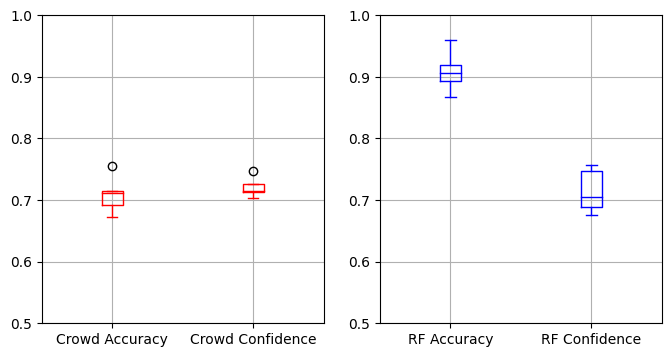

In [9]:
# plot a 2x2 boxplot vertical, left: crowd (accuracy, confidence), right: rf (accuracy, confidence)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
df_stats.boxplot(column=['Crowd Accuracy', 'Crowd Confidence'], ax=axs[0], color='red')
df_stats.boxplot(column=['RF Accuracy', 'RF Confidence'], ax=axs[1], color='blue')
#df_stats.boxplot(column=['Majority Vote Accuracy'], ax=axs[1], color='green')
# figure size
fig.set_size_inches(8, 4)
# set same y-axis
axs[0].set_ylim(0.5, 1)
axs[1].set_ylim(0.5, 1)
#axs[2].set_ylim(0.5, 1)
# plt.suptitle('Crowd (Simple Average/Majority) and Random Forest Comparison')
# plt.savefig('RFCrowd_1200_ModelConfidence.png')
plt.show()

In [ ]:
# per-image accuracy and confidence; 300 images
# 300 images x 20 networks x 100 crowds = 600,000 rows
# column: 0-9 confidence score for each; correct answer; predict answer.
# 0-9 confidence score for each network

In [ ]:
crowd_accs, crowd_confs, crowd_acc_means, crowd_conf_means = crowd_stats(50,20,binary=False)

##### Looking at Crowds.

In [104]:
# get the average, std, min and max of the averages
print("Average test accuracy: ", np.mean(crowd_acc_means))
print("Average test confidence: ", np.mean(crowd_conf_means))
# stds
print("Test accuracy std: ", np.std(crowd_acc_means))
print("Test confidence std: ", np.std(crowd_conf_means))

# range
print("Test accuracy range: ", np.max(crowd_acc_means), np.min(crowd_acc_means))
print("Test confidence range: ", np.max(crowd_conf_means), np.min(crowd_conf_means))

Average test accuracy:  0.6884218999999999
Average test confidence:  0.8220608
Test accuracy std:  0.019825693556342505
Test confidence std:  0.01450106857303969
Test accuracy range:  0.721936 0.6552060000000001
Test confidence range:  0.8514999999999999 0.799284


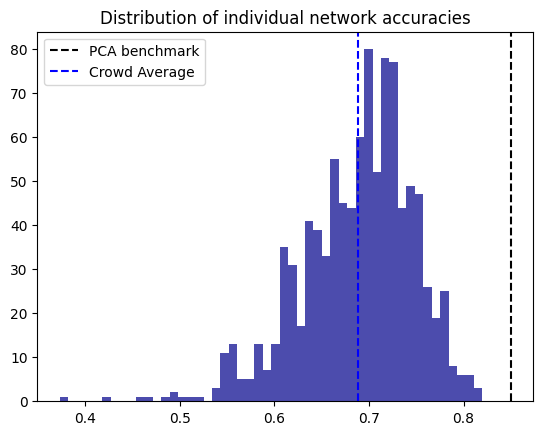

In [107]:
# probability histogram of distribution of all individual network accuracies
plt.hist(np.array(crowd_accs).flatten(), bins=50, color='darkblue', alpha=0.7)
plt.title('Distribution of individual network accuracies')
# add a x=0.78 line "PCA benchmark"
plt.axvline(x=0.85, color='black', linestyle='--', label='PCA benchmark')
# add another line "Crowd Average"
plt.axvline(x=np.mean(crowd_acc_means), color='blue', linestyle='--', label='Crowd Average')
plt.legend()
plt.savefig('crowd_accs_mutliclass.png')
plt.show()

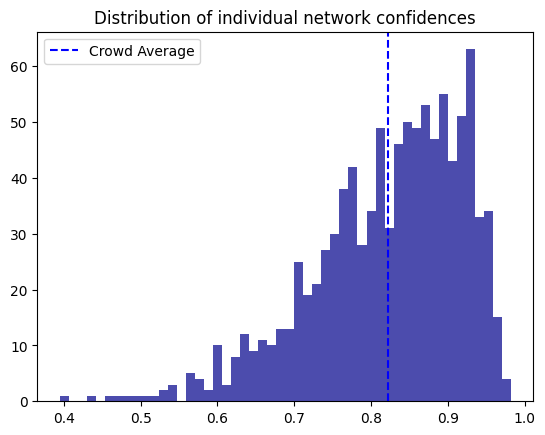

In [108]:
# probability histogram of distribution of all individual network confidences
plt.hist(np.array(crowd_confs).flatten(), bins=50, color='darkblue', alpha=0.7)
plt.title('Distribution of individual network confidences')
# add another line "Crowd Average"
plt.axvline(x=np.mean(crowd_conf_means), color='blue', linestyle='--', label='Crowd Average')
plt.legend()
plt.savefig('crowd_confs_multiclass.png')
plt.show()

## Voting Methods

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# PCA-based latent space
train_images, train_labels, test_images, test_labels = get_images(42,binary=False)
loop_num = 10

train_pca, test_pca, train_reconstructed, test_reconstructed = PCA_reduction(train_images, test_images, args.latent_dim, random_seed=0)
# Logistic regression classifier for PCA-based latent space
clf_pca = LogisticRegression(max_iter=loop_num)
clf_pca.fit(train_pca, train_labels)  # Train on PCA latent space
test_preds_pca = clf_pca.predict(test_pca)  # Predict on test set
# Compute accuracy
acc_pca = accuracy_score(test_labels, test_preds_pca)
print(f"Accuracy on test set using PCA: {acc_pca * 100:.2f}%")

Accuracy on test set using PCA: 85.67%


### Failed Attempts

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

def vote_majority(X):
    # along the second axis, find the most common element
    return np.array([Counter(column).most_common(1)[0][0] for column in X.T])

# Initialize a list to store the decision trees
decision_trees = []
prediction_trees = []
prediction_trees_probs = []

for i in range(loop_num): 
    # # Create a new decision tree
    tree = DecisionTreeClassifier(max_depth=3, random_state=i, max_features=8) # change max_features according to latent_dim
    # tree = RandomForestClassifier(n_estimators=loop_num, max_depth=5, random_state=i, max_features=64)
    # Fit the decision tree on the latent representations
    training_array = train_zs[i]
    tree.fit(training_array, train_labels)
    # Append the decision tree to the list
    decision_trees.append(tree)

    # Predict the test labels using the decision tree
    testing_array = test_zs[i]
    
    prediction_tree = tree.predict(testing_array)
    prediction_trees.append(prediction_tree)

    # Predict the test labels using the decision tree and calculate the probabilities
    prediction_tree_probs = tree.predict_proba(testing_array)
    prediction_trees_probs.append(prediction_tree_probs)

prediction_trees = np.array(prediction_trees)
prediction_trees_probs = np.array(prediction_trees_probs)

# vote for the majority
rf_predictions = vote_majority(prediction_trees)
# calculate the accuracy
print(f"Testing accuracy: {accuracy_score(test_labels, rf_predictions):.4f}")
# Calculate the average probability for each class across all trees
average_probs = np.mean(prediction_trees_probs, axis=0)
# Calculate the average confidence of the predictions
average_confidences = np.max(average_probs, axis=1)
average_confidence = np.mean(average_confidences)
print(f"Average confidence of predictions: {average_confidence:.4f}")

Testing accuracy: 0.1767
Average confidence of predictions: 0.1321


In [ ]:
# do the same analysis using XGBoost

from xgboost import XGBClassifier

# Initialize a list to store the XGBoost models
xgboost_models = []
prediction_xgboost = []
prediction_xgboost_probs = []

for i in range(loop_num):
    # Create a new XGBoost model
    xgboost = XGBClassifier(n_estimators=loop_num, random_state=i, learning_rate=0.1)
    # Fit the XGBoost model on the latent representations
    training_array = train_zs[i]
    xgboost.fit(training_array, train_labels)
    # Append the XGBoost model to the list
    xgboost_models.append(xgboost)

    # Predict the test labels using the XGBoost model
    testing_array = test_zs[i]
    prediction_xgb = xgboost.predict(testing_array)
    prediction_xgboost.append(prediction_xgb)

    # Predict the test labels using the XGBoost model and calculate the probabilities
    prediction_xgb_probs = xgboost.predict_proba(testing_array)
    prediction_xgboost_probs.append(prediction_xgb_probs)

prediction_xgboost = np.array(prediction_xgboost)
prediction_xgboost_probs = np.array(prediction_xgboost_probs)

# vote for the majority
xgboost_predictions = vote_majority(prediction_xgboost)
# calculate the accuracy
print(f"Testing accuracy: {accuracy_score(test_labels, xgboost_predictions):.4f}")
# Calculate the average probability for each class across all trees
average_probs = np.mean(prediction_xgboost_probs, axis=0)
# Calculate the average confidence of the predictions
average_confidences = np.max(average_probs, axis=1)
average_confidence = np.mean(average_confidences)
print(f"Average confidence of predictions: {average_confidence:.4f}")

Testing accuracy: 0.1333
Average confidence of predictions: 0.1234
